In [1]:
%reload_ext autoreload
%autoreload 2

import os
import sys
import numpy as np
from astropy import units as u
from astropy import constants as c
import gc
from tqdm import tqdm
from scipy import interpolate

sys.path.append(os.environ['DM21CM_DIR'])
from dm21cm.injections.pbh import PBHAccretionInjection
from dm21cm.utils import load_h5_dict

import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc_file('../../matplotlibrc')

# pbhacc-L-z

In [13]:
model_name_s = ['PRc23', 'PRc10', 'PRc50', 'PRc23B', 'PRc23d', 'PRc23H', 'BHLl2']

z_s = np.geomspace(4, 1000, 100)

unity = (1 * u.eV/u.s/u.cm**3 / c.c**2).to(u.M_sun/u.yr/u.Mpc**3)

cf_halo_power_s = []
cf_cosmo_power_s = []
cf_total_power_s = []
for name in tqdm(model_name_s):
    inj = PBHAccretionInjection(name, m_PBH=100, f_PBH=1)
    cf_halo_power_s.append(np.array([inj.inj_power(z, debug='halo only') / (1+z)**3 for z in z_s]) * unity.value)
    cf_cosmo_power_s.append(np.array([inj.inj_power(z, debug='cosmo only') / (1+z)**3 for z in z_s]) * unity.value)
    del inj
    gc.collect()
cf_halo_power_s = np.array(cf_halo_power_s)
cf_cosmo_power_s = np.array(cf_cosmo_power_s)
cf_total_power_s = cf_halo_power_s + cf_cosmo_power_s

100%|██████████| 7/7 [00:23<00:00,  3.40s/it]


In [21]:
model_latex_dict = {
    'PRc23': r'$\textbf{PR}\,\mathrm{(fid.)}$',
    'PRc10': r'$\textbf{PR-}c-$',
    'PRc50': r'$\textbf{PR-}c+$',
    'PRc23B': r'$\textbf{PR-}B$',
    'PRc23d': r'$\textbf{PR-}\delta_e$',
    'PRc23H': r'$\textbf{PR-}H$',
    'BHLl2': r'$\textbf{BHL}$',
}
color_dict = {
    'PRc23': 'k',
    'PRc10': 'C0',
    'PRc50': 'C1',
    'PRc23B': 'C2',
    'PRc23d': 'C3',
    'PRc23H': 'C4',
    'BHLl2': 'k',
}
ls_dict = {
    'PRc23': '-',
    'PRc10': '-',
    'PRc50': '-',
    'PRc23B': '-',
    'PRc23d': '-',
    'PRc23H': '-',
    'BHLl2': '--',
}
zorder_dict = {
    'PRc23': 6,
    'PRc10': 5,
    'PRc50': 4,
    'PRc23B': 3,
    'PRc23d': 2,
    'PRc23H': 1,
    'BHLl2': 0,
}

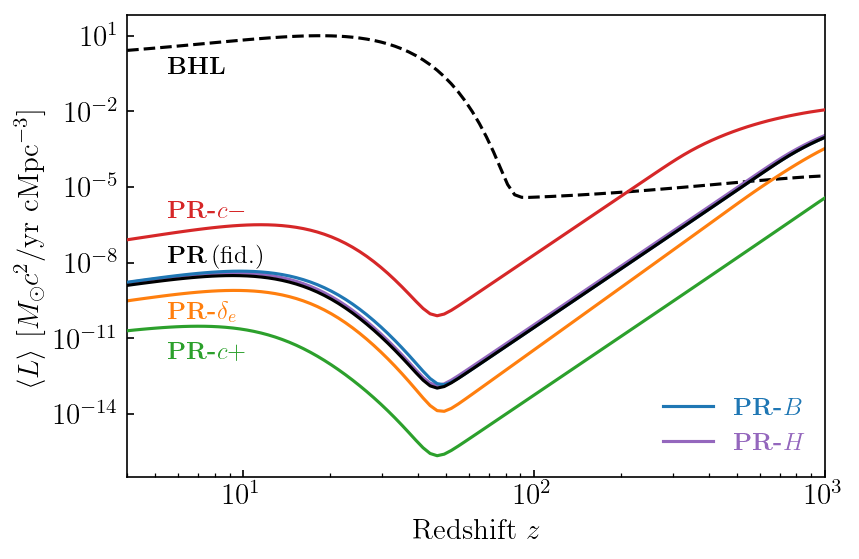

In [24]:
fig, axs = plt.subplots(1, 1, figsize=(6, 4))

ax = axs

text_xy_dict = {
    'PRc23': [5.5, 10**-8],
    'PRc10': [5.5, 10**-6.2],
    'PRc50': [5.5, 10**-11.8],
    'PRc23B': None,
    'PRc23d': [5.5, 10**-10.2],
    'PRc23H': None,
    'BHLl2': [5.5, 10**-0.5],
}

for i, mn in enumerate(model_name_s):
    # ax.plot(z_s, cf_halo_power_s[i], color=color_s[i], alpha=0.5, zorder=zorder_s[i], ls=ls_s[i])
    # ax.plot(z_s, cf_cosmo_power_s[i], color=color_s[i], alpha=0.5, zorder=zorder_s[i], ls=ls_s[i])
    label = model_latex_dict[mn] if not text_xy_dict[mn] else None
    ax.plot(z_s, cf_total_power_s[i], color=color_dict[mn], label=label, zorder=zorder_dict[mn], ls=ls_dict[mn], lw=1.5)
    if text_xy_dict[mn]:
        ax.text(*text_xy_dict[mn], model_latex_dict[mn], color=color_dict[mn], fontsize=12)
ax.set(xscale='log', yscale='log')
ax.set(xlim=(4, 1000))
ax.set(xlabel=r'Redshift $z$', ylabel=r'$\langle L\rangle$ [$M_\odot c^2$/yr cMpc$^{-3}$]')
legend = ax.legend(frameon=False, loc='lower right')
legend_colors = ['C2', 'C4']
for text, color in zip(legend.get_texts(), legend_colors):
    text.set_color(color)

fig.savefig('pbhacc-L-z.pdf', bbox_inches='tight')

# pbhacc-L-M

In [30]:
hmfdata = load_h5_dict("/n/holystore01/LABS/iaifi_lab/Users/yitians/dm21cm/data/hmf/hmf.h5")
z_s = hmfdata['z'] # [1]    | redshift
d_s = hmfdata['d'] # [1]    | delta (overdensity)
m_s = hmfdata['m'] # [Msun] | halo mass

In [33]:
model_name_s = ['BHLl2', 'PRc23', 'PRc10', 'PRc50', 'PRc23B', 'PRc23d', 'PRc23H']
L_dict = {}

z = 10

for model_name in model_name_s:
    L_table = np.load(f"../../data/pbh-accretion/L_table_cache/{model_name}/{model_name}_log10m2.000.npy")
    L_dict[model_name] = interpolate.interp1d(z_s, L_table, axis=0, bounds_error=True)(z)

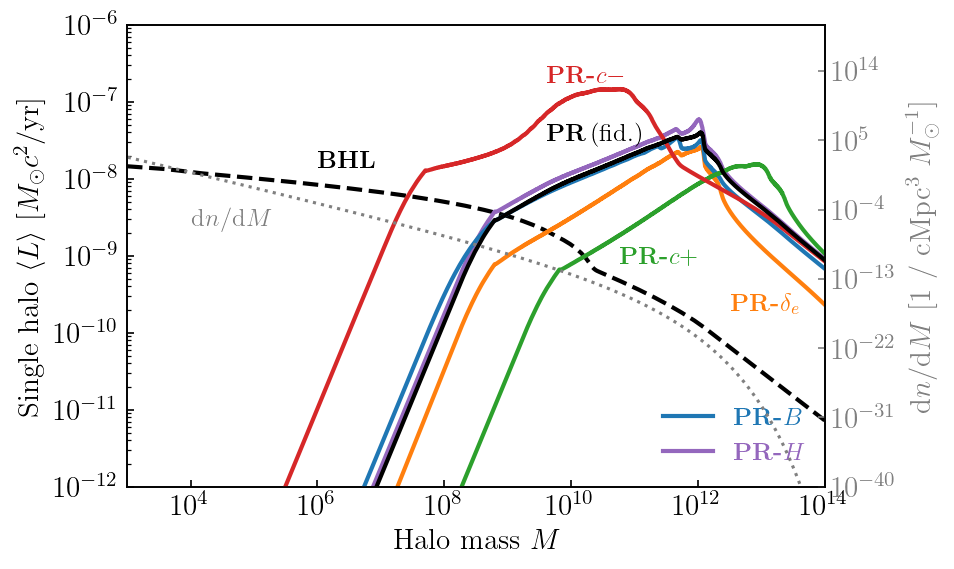

In [45]:
text_log10xy_dict = {
    'PRc23': [9.6, -7.5],
    'PRc10': [9.6, -6.75],
    'PRc50': [10.75, -9.1],
    'PRc23B': None,
    'PRc23d': [12.5, -9.7],
    'PRc23H': None,
    'BHLl2': [6, -7.85],
}

fig, ax = plt.subplots(1, 1, figsize=(6, 4))

for i, mn in enumerate(model_name_s):
    log10xy = text_log10xy_dict[mn]
    if log10xy:
        xy = 10.**np.array(log10xy)
        ax.text(*xy, model_latex_dict[mn], color=color_dict[mn], fontsize=12)
        label = None
    else:
        label = model_latex_dict[mn]
    ax.plot(m_s, L_dict[mn], label=label, color=color_dict[mn], ls=ls_dict[mn], zorder=zorder_dict[mn])
ax.set(xscale='log', yscale='log')
ax.set(xlim=(1e3, 1e14), ylim=(1e-12, 1e-6))
ax.set(xlabel=r'Halo mass $M$', ylabel=r'Single halo $\langle L\rangle$ [$M_\odot c^2$/yr]')

ax2 = ax.twinx()
dndm_s = interpolate.interp1d(z_s, hmfdata['st'], axis=0, bounds_error=True)(z)
ax2.plot(m_s, dndm_s, color='gray', ls=':', lw=1.5, zorder=-1, label=r'$\mathrm{d}n/\mathrm{d}M$')
ax2.tick_params(axis='y', colors='gray') 
ax2.set(yscale='log')
ax2.set(ylim=(1e-40, 1e20))
ax2.set_ylabel(r'$\mathrm{d}n/\mathrm{d}M$ [1 / cMpc$^{3}$ $M_\odot^{-1}$]', color='gray')
ax2.text(1e4, 1e-6, r'$\mathrm{d}n/\mathrm{d}M$', color='gray', fontsize=12)

legend = ax.legend(frameon=False, fontsize=12, loc='lower right')
legend_colors = ['C2', 'C4']
for text, color in zip(legend.get_texts(), legend_colors):
    text.set_color(color)

fig.savefig('pbhacc-L-M.pdf', bbox_inches='tight')